Trying to find heuristic for bright vs dark qualities

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import librosa
import os

from tqdm import tqdm
from IPython.display import Audio
from clf.data_loader import data_loader
from clf.config import get_config

plt.style.use("dark_background")


In [235]:
SR = 16000

f = "pure_vs_noisy"
classes = f.split("_")

conf = get_config()
conf["features"] = [f]

examples = data_loader(conf)

def get_class(value: int):
    if value < 30:
        return 0
    elif value > 70:
        return 2
    else:
        return 1

def get_high_low_ratio(file_name: str, r: float = 0.5):
    audio, _ = librosa.load(file_name, sr=SR, mono=True)
    clip_at = SR * 2
    spec = librosa.feature.melspectrogram(audio[:clip_at], sr=SR)
    log_spec = librosa.power_to_db(spec).mean(axis=-1)
    dim = log_spec.shape[0]
    split_at = int(r * dim)
    # only consider values higher than -30db
    indices = np.where(log_spec > -30.)
    log_spec = log_spec[indices]
    # ratio of energy in first r% frequency bins vs total
    if len(log_spec) > 0:
        return log_spec[:split_at].mean(), log_spec.mean()
    else:
        return None

def get_file_path(file_name):
    return os.path.join(conf.get("base_dir"), f"{file_name}.wav")

2021-05-09 10:47:42.098 | INFO     | clf.data_loader:data_loader:29 - Loading csv and checking audio files
2021-05-09 10:47:42.109 | INFO     | clf.data_loader:data_loader:32 - Creating dataset


In [236]:
results = []

for file_name, value in tqdm(examples.items()):

    file_path = get_file_path(file_name)
    res = get_high_low_ratio(file_path, 0.25)
    if res is not None:
        low, total = res
        c = get_class(value.get(f))
        if c != 1:
            results.append((c, low, total))

results = np.array(results)

100%|██████████| 1890/1890 [00:09<00:00, 197.61it/s]


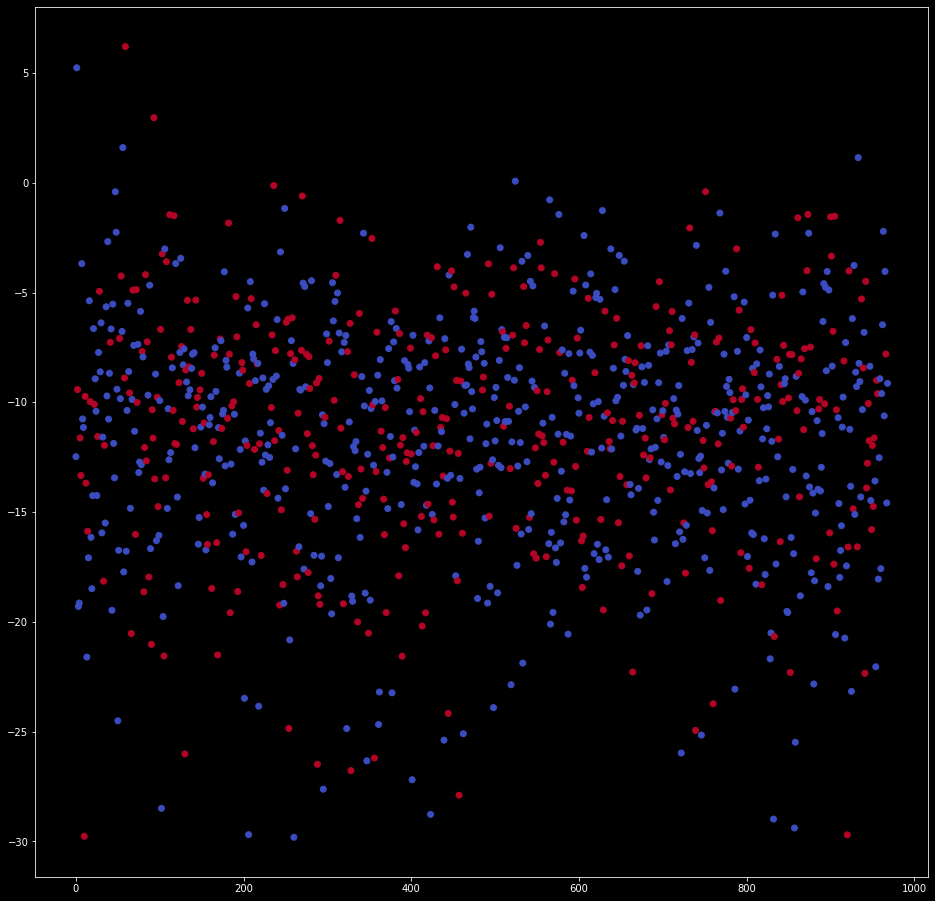

In [237]:
plt.figure(figsize=(16, 16))
plt.scatter(
    x=range(0, len(results)),
    y=results[:, 1], # / results[:, 2],
    c=results[:, 0],
    cmap="coolwarm"
)
# plt.ylim([-20., 0.])
plt.show()

In [238]:
def get_avg(index):
    _indices = np.where(results[:, 0] == index)

    _results = results[_indices]
    _ratio_avg = _results[:, 1] / _results[:, 2]

    return _ratio_avg.mean(), _results[:, 2].mean()

In [239]:
print(classes[0], get_avg(0))
# print(classes[1], get_avg(1))
print(classes[2], get_avg(2))

pure (0.9571950830925304, -12.212156316329693)
noisy (0.8898286114045413, -11.881836859686516)
